In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
custom_palette = sns.color_palette("tab10", n_colors=2)

In [4]:
data_path = "./jade_apex_filtered.csv"

/tmp/ipykernel_19397/1982904215.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time(h)"] = data["time_total_s"] / 3600
/tmp/ipykernel_19397/1982904215.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time_group"] = (data["time(h)"] // window_size) * window_size
/tmp/ipykernel_19397/1982904215.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

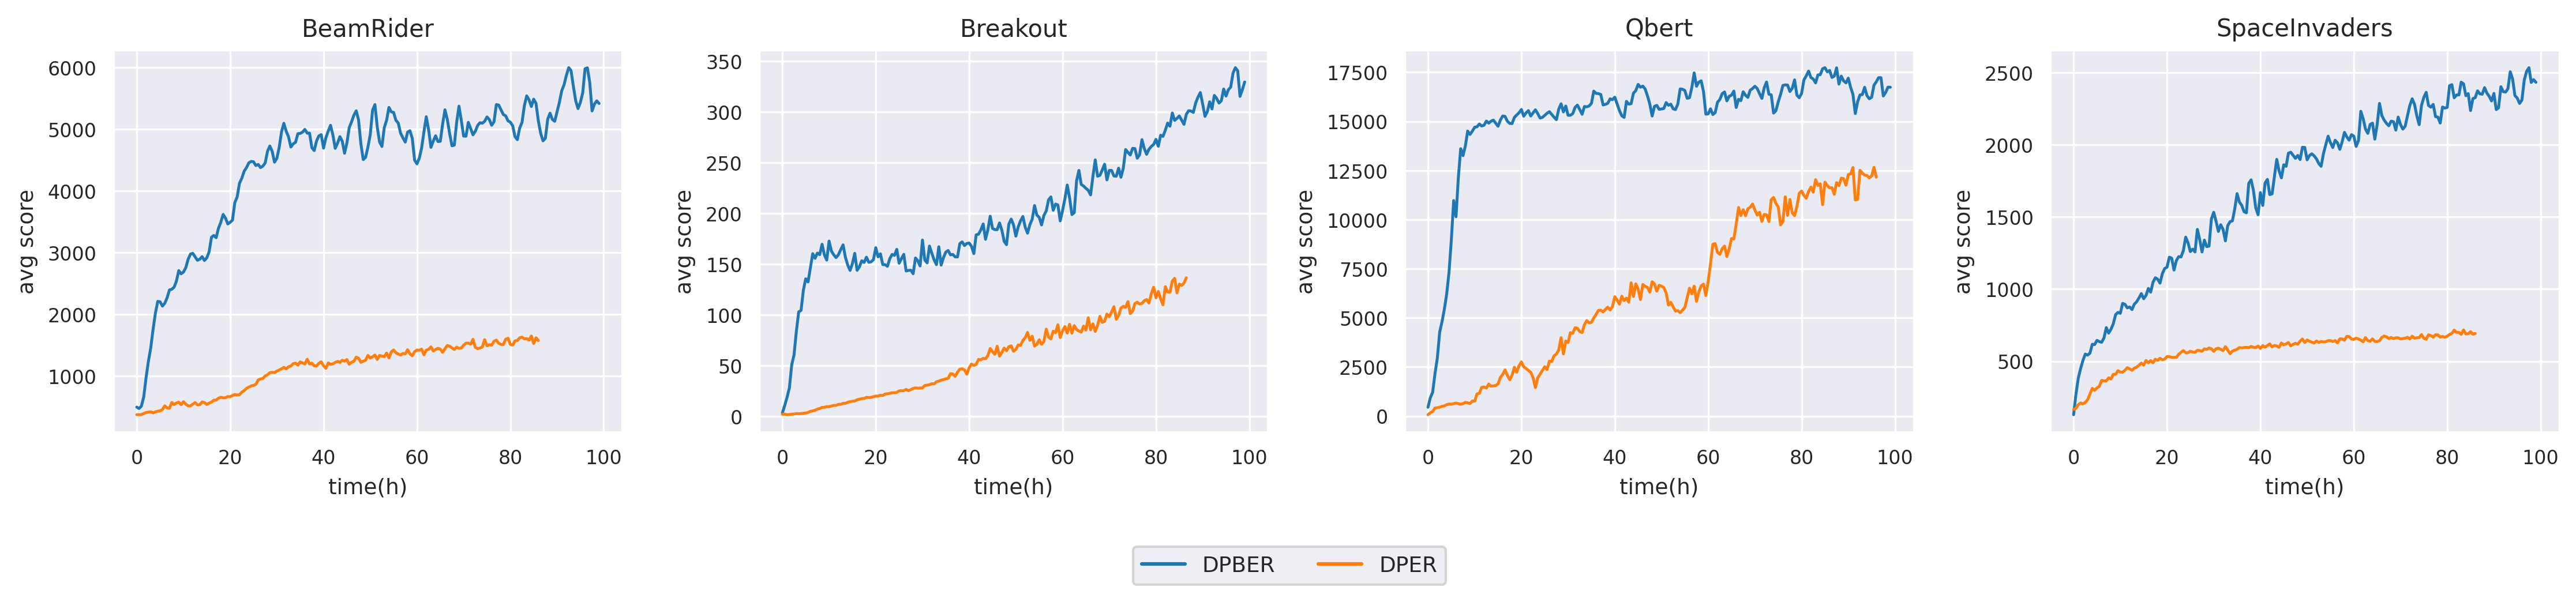

In [7]:
data_df = pd.read_csv(data_path)
data_df = data_df[data_df["size"].isin([1, 32])]
data_df = data_df[data_df["env"].isin(["BeamRider", "Breakout", "Qbert", "SpaceInvaders"])]
# Filter the environments
data_df["time(h)"] = data_df["time_total_s"] / 3600
sampler = {env: data_df[data_df['env'] == env] for env in data_df['env'].unique()}
window_size = 0.25

def compute_rolling_mean(data, window_size=0.5):
    data["time(h)"] = data["time_total_s"] / 3600
    data["time_group"] = (data["time(h)"] // window_size) * window_size
    smoothed_data = data.groupby(["time_group", "buffer"])["episode_reward_mean"].mean().reset_index()
    return smoothed_data

smoothed_sampler = {env: compute_rolling_mean(data) for env, data in sampler.items()}

fig, axes = plt.subplots(1, 4, figsize=(15, 3), dpi=300)
axes = axes.reshape(-1)
all_lines = []
all_labels = []

for ax_n, (env, data) in enumerate(smoothed_sampler.items()):
    ax = sns.lineplot(x="time_group", y="episode_reward_mean", hue="buffer", data=data.iloc[:-2,], ax=axes[ax_n], palette=custom_palette, linewidth=1.2)
    ax.set_title(env, fontsize=10)
    ax.set_xlabel("time(h)", fontsize=9)
    ax.set_ylabel("avg score", fontsize=9)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    
    # Collect legend data for each subplot
    handles, labels = ax.get_legend_handles_labels()
    all_lines.extend(handles)  
    all_labels.extend(labels)  
    
    # Remove the legend from the subplot
    ax.get_legend().remove()

# Create a unique set of legend labels and their corresponding lines
unique_labels, unique_lines = zip(*dict(zip(all_labels, all_lines)).items())
fig.legend(unique_lines, unique_labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=len(unique_labels), fontsize=9)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, bottom=0.15)
plt.show()

/tmp/ipykernel_2287/3811390120.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time(h)"] = data["time_total_s"] / 3600
/tmp/ipykernel_2287/3811390120.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time_group"] = (data["time(h)"] // window_size) * window_size
/tmp/ipykernel_2287/3811390120.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

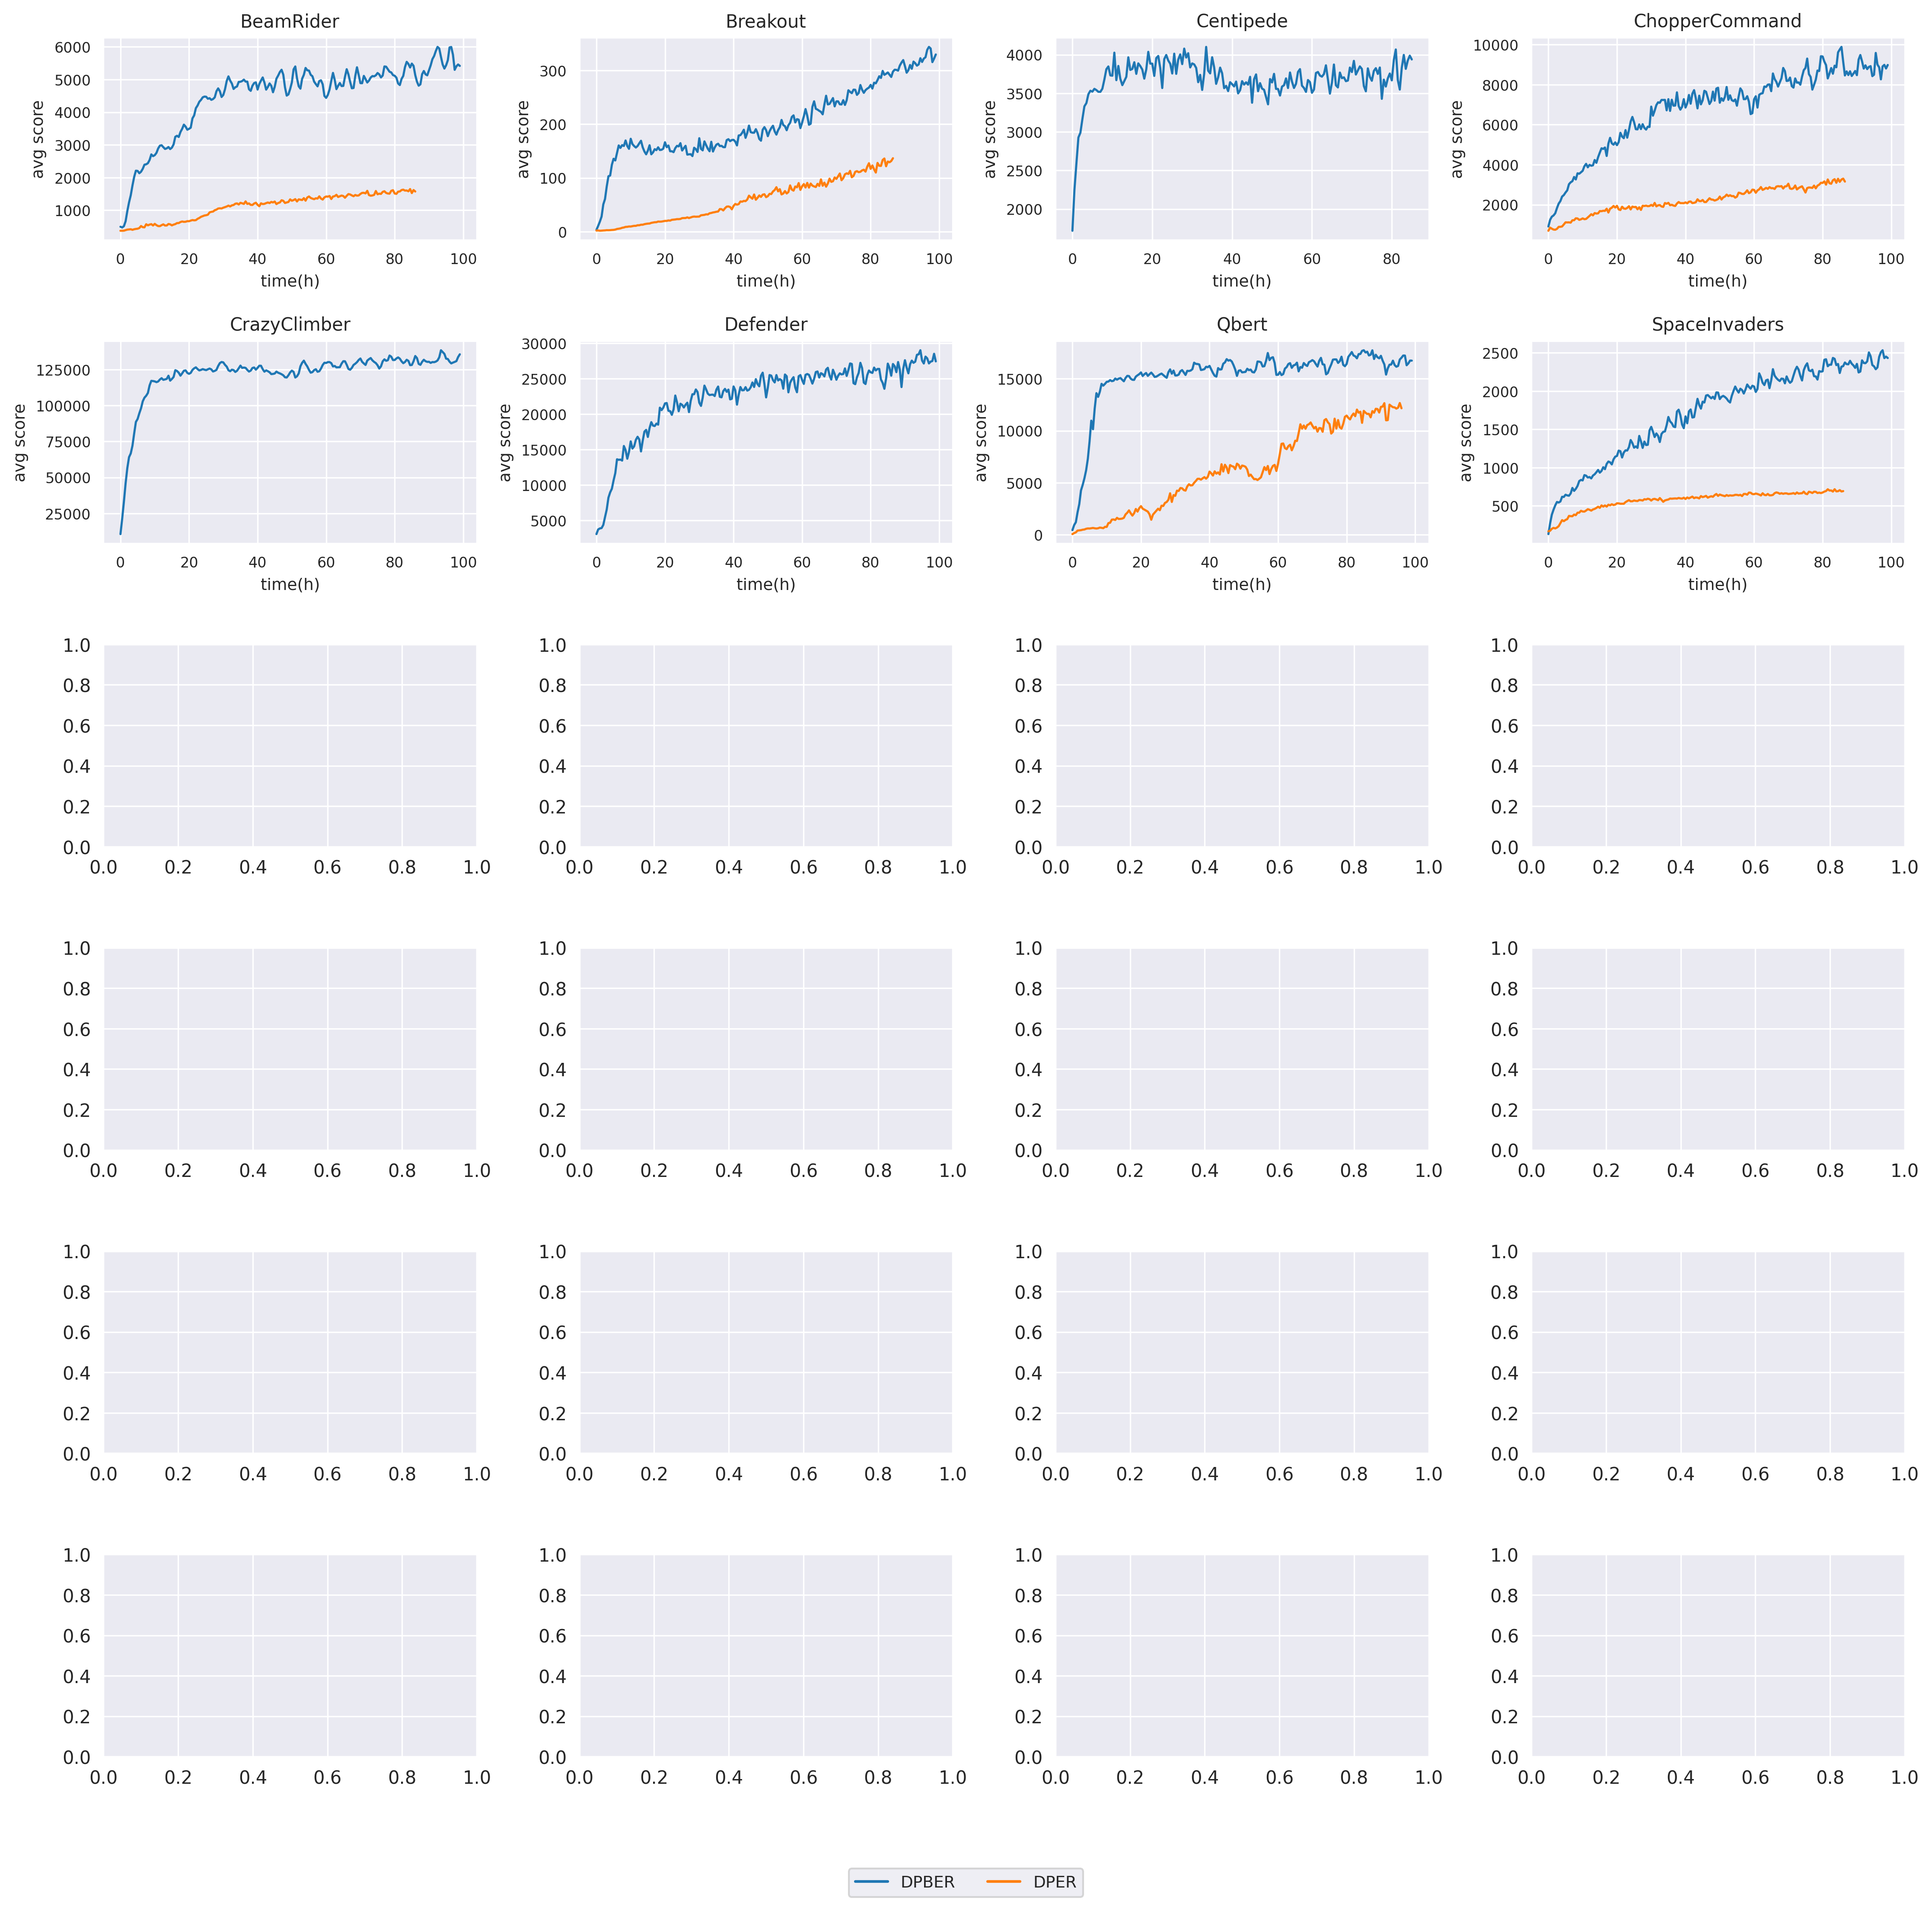

In [23]:
data_df = pd.read_csv(data_path)
data_df = data_df[data_df["size"].isin([1, 32])]
# Filter the environments
data_df["time(h)"] = data_df["time_total_s"] / 3600
sampler = {env: data_df[data_df['env'] == env] for env in data_df['env'].unique()}
window_size = 0.25

def compute_rolling_mean(data, window_size=0.5):
    data["time(h)"] = data["time_total_s"] / 3600
    data["time_group"] = (data["time(h)"] // window_size) * window_size
    smoothed_data = data.groupby(["time_group", "buffer"])["episode_reward_mean"].mean().reset_index()
    return smoothed_data

smoothed_sampler = {env: compute_rolling_mean(data) for env, data in sampler.items()}

fig, axes = plt.subplots(6, 4, figsize=(15, 16), dpi=300)
axes = axes.reshape(-1)
all_lines = []
all_labels = []

for ax_n, (env, data) in enumerate(smoothed_sampler.items()):
    ax = sns.lineplot(x="time_group", y="episode_reward_mean", hue="buffer", data=data.iloc[:-2,], ax=axes[ax_n], palette=custom_palette, linewidth=1.2)
    ax.set_title(env, fontsize=10)
    ax.set_xlabel("time(h)", fontsize=9)
    ax.set_ylabel("avg score", fontsize=9)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    
    # Collect legend data for each subplot
    handles, labels = ax.get_legend_handles_labels()
    all_lines.extend(handles)  
    all_labels.extend(labels)  
    
    # Remove the legend from the subplot
    ax.get_legend().remove()

# Create a unique set of legend labels and their corresponding lines
unique_labels, unique_lines = zip(*dict(zip(all_labels, all_lines)).items())
fig.legend(unique_lines, unique_labels, loc="upper center", bbox_to_anchor=(0.5, 0.1), ncol=len(unique_labels), fontsize=9)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, bottom=0.15)
plt.show()

/tmp/ipykernel_2287/3032509772.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time_group"] = (data["num_env_steps_sampled"] // window_size) * window_size
/tmp/ipykernel_2287/3032509772.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time_group"] = data["time_group"] * 4
/tmp/ipykernel_2287/3032509772.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

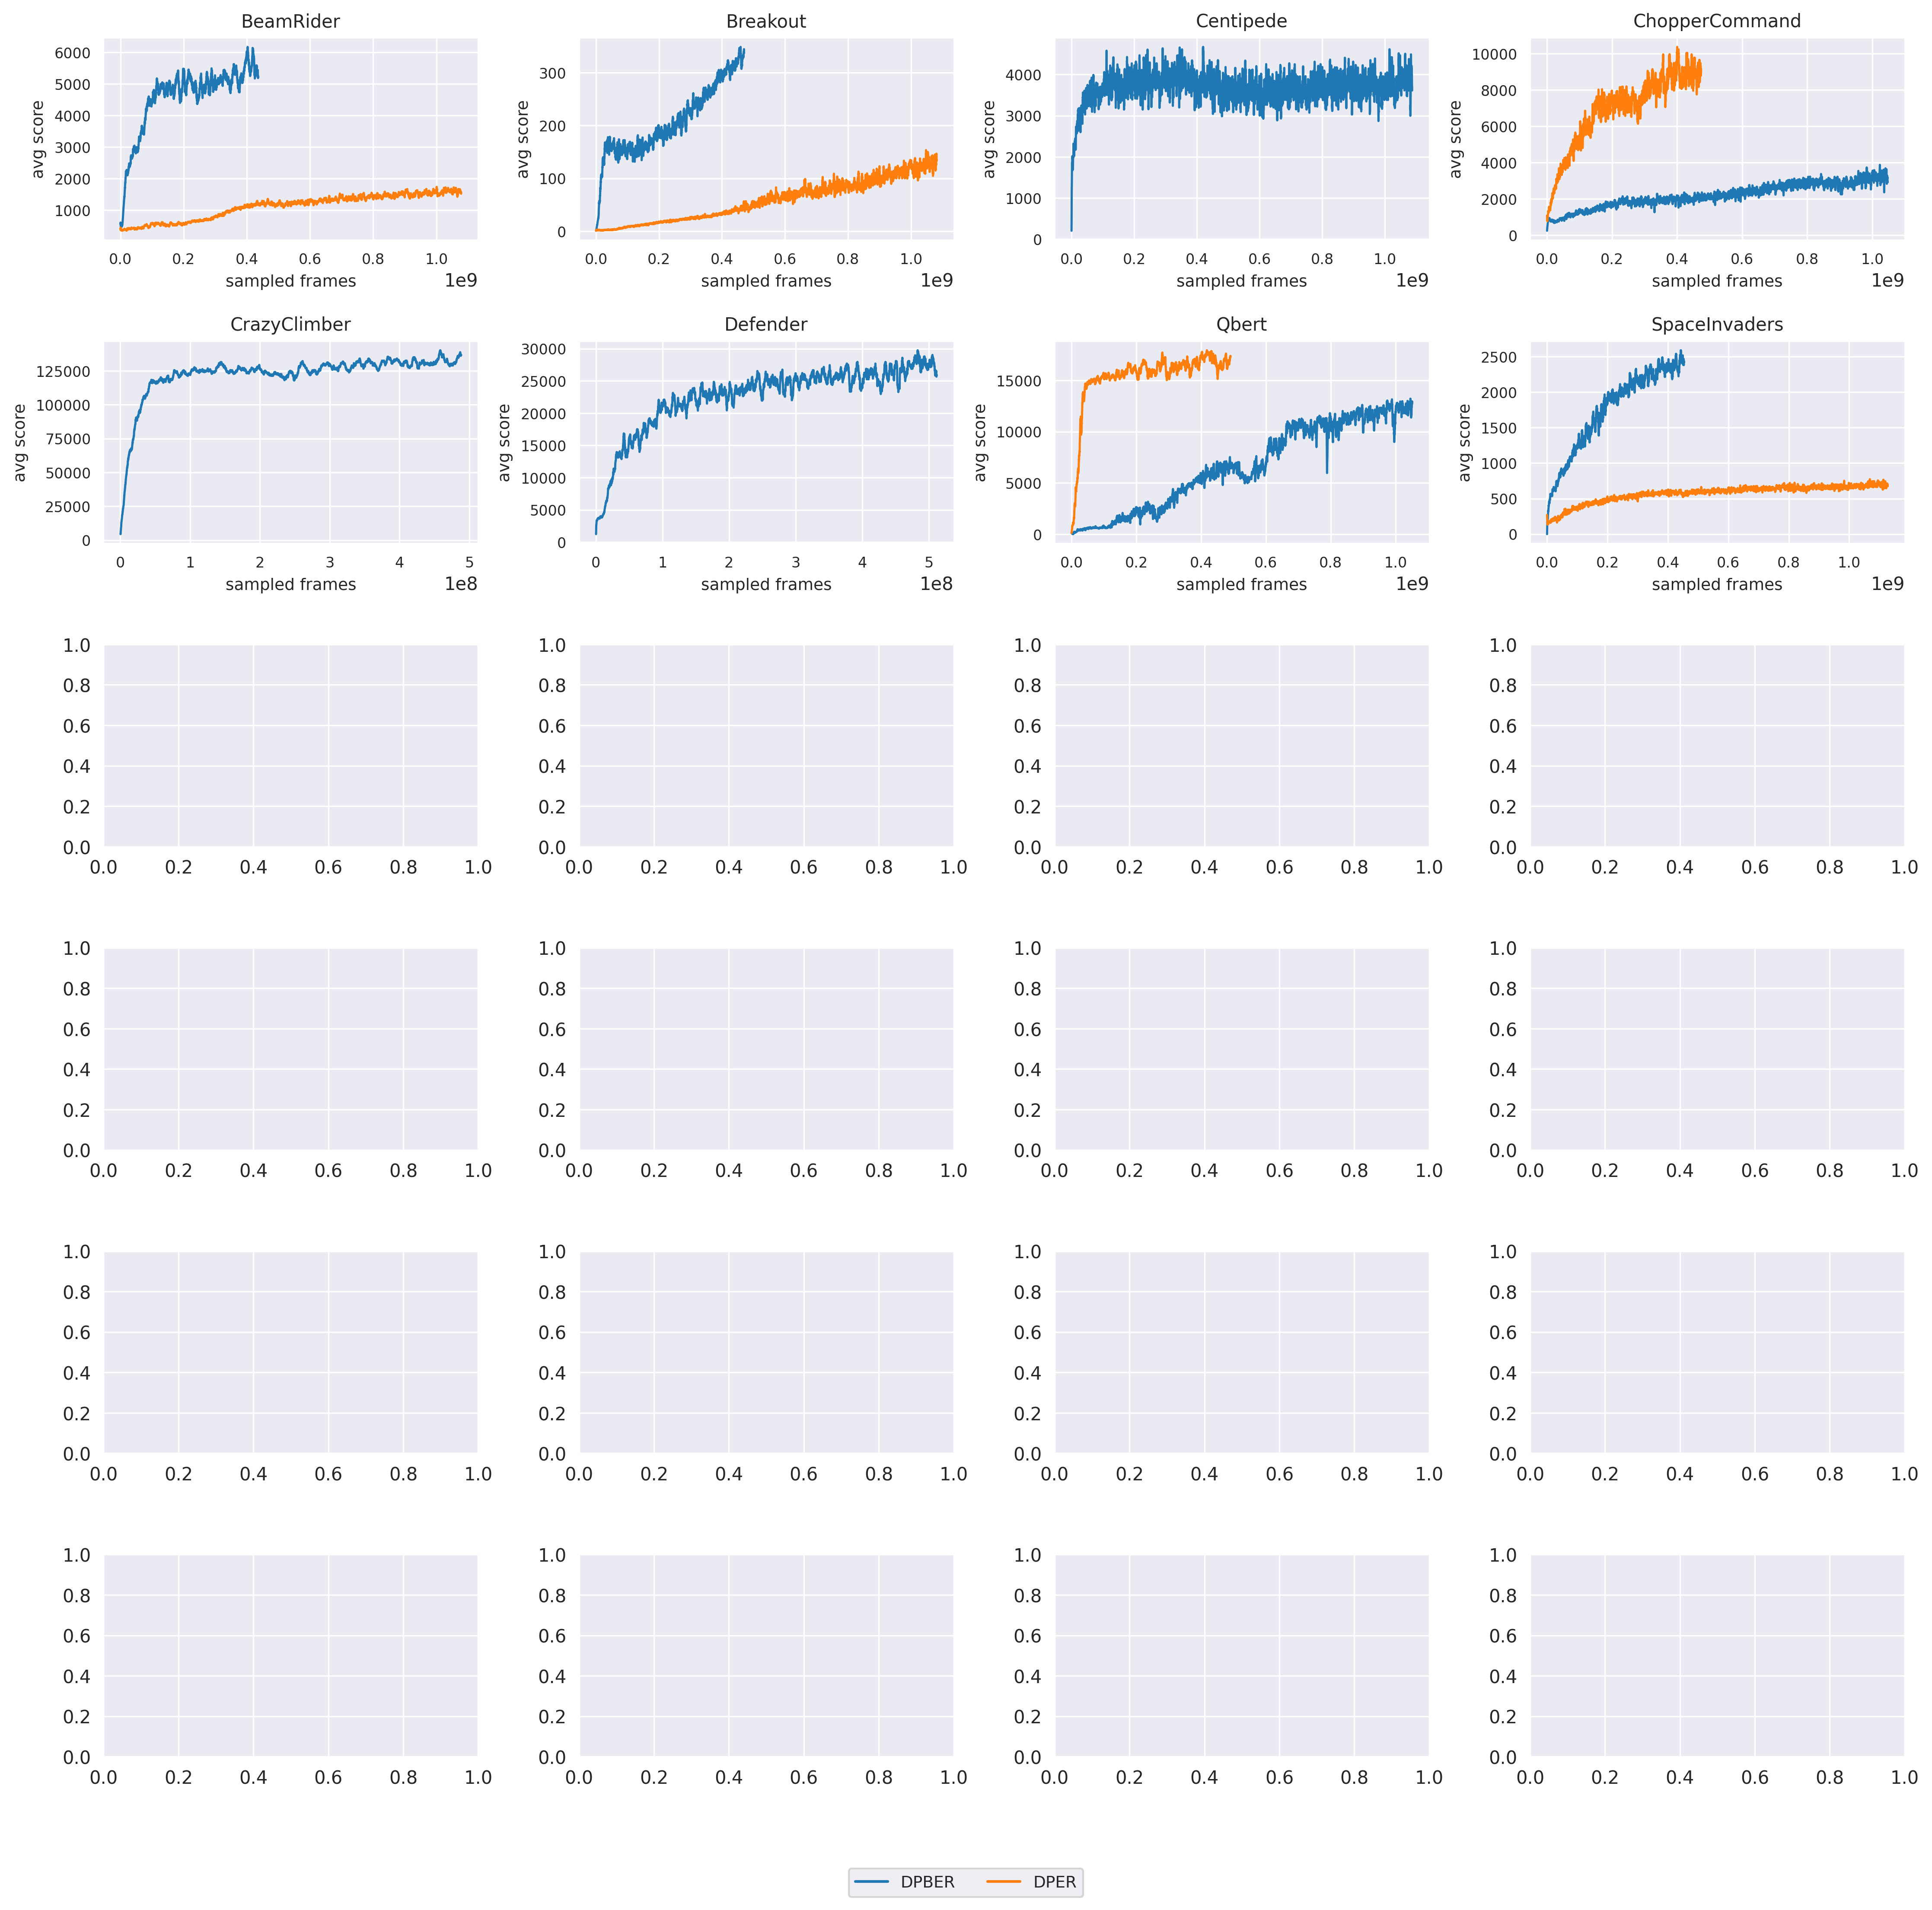

In [22]:
data_df = pd.read_csv(data_path)
data_df = data_df[data_df["size"].isin([1, 32])]
# Original code provided to generate the plot
sampler = {env: data_df[data_df['env'] == env] for env in data_df['env'].unique()}
window_size = 10000

def compute_rolling_mean(data, window_size=0.5):
    data["time_group"] = (data["num_env_steps_sampled"] // window_size) * window_size
    data["time_group"] = data["time_group"] * 4
    smoothed_data = data.groupby(["time_group", "buffer"])[["episode_reward_mean"]].mean().reset_index()
    return smoothed_data

smoothed_sampler = {env: compute_rolling_mean(data) for env, data in sampler.items()}

custom_palette = sns.color_palette("tab10")

fig, axes = plt.subplots(6, 4, figsize=(15, 16), dpi=300)
axes = axes.reshape(-1)
all_lines = []
all_labels = []

for ax_n, (env, data) in enumerate(smoothed_sampler.items()):
    ax = sns.lineplot(x="time_group", y="episode_reward_mean", hue="buffer", data=data.iloc[:-2,], ax=axes[ax_n], palette=custom_palette, linewidth=1.2)
    ax.set_title(env, fontsize=10)
    ax.set_xlabel("sampled frames", fontsize=9)
    ax.set_ylabel("avg score", fontsize=9)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    
    # Collect legend data for each subplot
    handles, labels = ax.get_legend_handles_labels()
    all_lines.extend(handles)
    all_labels.extend(labels)
    
    # Remove the legend from the subplot
    ax.get_legend().remove()

# Create a unique set of legend labels and their corresponding lines
unique_labels, unique_lines = zip(*dict(zip(all_labels, all_lines)).items())
fig.legend(unique_lines, unique_labels, loc="upper center", bbox_to_anchor=(0.5, 0.1), ncol=len(unique_labels), fontsize=9)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, bottom=0.15)
plt.show()

In [41]:
data_df = pd.read_csv(data_path)
data_df = data_df[data_df["size"].isin([1, 32])]
n = 5
window_size_hours = 0.25
data_df["time(h)"] = data_df["time_total_s"] / 3600

# 2. Define helper functions
def apply_offsets_to_data(data):
    recommended_offsets = {
        'Boxing': 20,
        'Pong': 21,
        'FishingDerby': 100,
        'Frostbite': 5,
        'Enduro': 10,
        'Q*bert': 0
    }
    for env, min_reward in data.groupby('env')['episode_reward_mean'].min().items():
        if env not in recommended_offsets and min_reward < 0:
            recommended_offsets[env] = abs(min_reward) + 1
    data['episode_reward_mean'] = data.apply(lambda row: row['episode_reward_mean'] + recommended_offsets.get(row['env'], 0), axis=1)
    return data

def compute_interval_mean_with_env(env_data):
    env_name = env_data['env'].iloc[0]
    bins = list(np.arange(0, env_data["time(h)"].max() + window_size_hours, window_size_hours))
    env_data["time_interval"] = pd.cut(env_data["time(h)"], bins, labels=bins[:-1], right=False)
    numeric_cols = env_data.select_dtypes(include=[np.number]).columns.tolist()
    interval_data = env_data.groupby('time_interval')[numeric_cols].mean().reset_index()
    interval_data['env'] = env_name
    return interval_data

def compute_avg_reward_last_episodes(env_name, data1, data2, n):
    last_rewards1 = data1[data1['env'] == env_name]['episode_reward_mean'].tail(n).values
    last_rewards2 = data2[data2['env'] == env_name]['episode_reward_mean'].tail(n).values
    avg_reward1 = last_rewards1.mean()
    avg_reward2 = last_rewards2.mean()
    return avg_reward1, avg_reward2

def compute_T_save_for_env(env_name, data1, data2):
    rewards1 = data1[data1['env'] == env_name]['episode_reward_mean'].values
    rewards2 = data2[data2['env'] == env_name]['episode_reward_mean'].values
    if len(rewards1) == 0 or len(rewards2) == 0:
        return None
    times1 = data1[data1['env'] == env_name]['time(h)'].values
    times2 = data2[data2['env'] == env_name]['time(h)'].values
    time_diff_ratios = []
    max_reward = max(rewards1.max(), rewards2.max())
    reward_samples = np.linspace(0, max_reward, 51)
    for target_reward in reward_samples:
        time1 = next((times1[i] for i, r in enumerate(rewards1) if r >= target_reward), None)
        time2 = next((times2[i] for i, r in enumerate(rewards2) if r >= target_reward), None)
        if time1 is not None and time2 is not None:
            time_diff_ratio = (time1 - time2) / time1
            time_diff_ratios.append(time_diff_ratio)
    return np.median(time_diff_ratios) if time_diff_ratios else None

# 3. Main data processing and analysis steps
# Sort data by time
data_df_sorted = data_df.sort_values(by=["env", "time(h)"])
# Apply offsets to the data
data_df_sorted = apply_offsets_to_data(data_df_sorted)

# Split sorted data for ER vs. BER and PER vs. PBER
er_data_sorted = data_df_sorted[data_df_sorted['buffer'] == 'DPER']
ber_data_sorted = data_df_sorted[data_df_sorted['buffer'] == 'DPBER']

# Compute interval mean for each buffer type and environment using sorted data
er_interval_data_sorted = pd.concat([compute_interval_mean_with_env(er_data_sorted[er_data_sorted['env'] == env]) for env in er_data_sorted['env'].unique()])
ber_interval_data_sorted = pd.concat([compute_interval_mean_with_env(ber_data_sorted[ber_data_sorted['env'] == env]) for env in ber_data_sorted['env'].unique()])

# Compute metrics for ER vs. BER and PER vs. PBER using sorted data
results_sorted = []
for env in data_df_sorted['env'].unique():
    R_improve_er_ber = (ber_interval_data_sorted[ber_interval_data_sorted['env'] == env]["episode_reward_mean"].median() - er_interval_data_sorted[er_interval_data_sorted['env'] == env]["episode_reward_mean"].median()) / ber_interval_data_sorted[ber_interval_data_sorted['env'] == env]["episode_reward_mean"].median()

    T_save_er_ber = compute_T_save_for_env(env, er_data_sorted, ber_data_sorted)
    
    avg_er_reward, avg_ber_reward = compute_avg_reward_last_episodes(env, er_data_sorted, ber_data_sorted, n)
    
    improvement_percentage_er_ber = ((avg_ber_reward - avg_er_reward) / avg_er_reward)  if avg_er_reward != 0 else np.nan
    
    results_sorted.append({
        'Environment': env,
        'R_improve_DPER_DPBER': R_improve_er_ber,
        'T_save_DPER_DPBER': T_save_er_ber,
        'R_last_DPER_DPBER': improvement_percentage_er_ber,
    })

# Convert results to a DataFrame and compute mean values
result_df_sorted = pd.DataFrame(results_sorted).set_index('Environment')

# 4. Calculate the average rates for num_env_steps_sampled and num_env_steps_trained per env and buffer
data_df['sampled/s'] = data_df['num_env_steps_sampled'] / data_df['time_total_s']
data_df['trained/s'] = data_df['num_env_steps_trained'] / data_df['time_total_s']

# Group by env and buffer and calculate mean rates
grouped_rates = data_df.groupby(['env', 'buffer'])[['sampled/s', 'trained/s']].mean().reset_index()

# Separate the rates for DPER and DPBER
dper_rates = grouped_rates[grouped_rates['buffer'] == 'DPER'].set_index('env')[['sampled/s', 'trained/s']]
dpber_rates = grouped_rates[grouped_rates['buffer'] == 'DPBER'].set_index('env')[['sampled/s', 'trained/s']]

# Calculate the ratio of DPBER to DPER for sampled and trained rates
rate_ratios = dpber_rates / dper_rates
rate_ratios = rate_ratios.reset_index()

# Append rate ratios to result_df_sorted
result_df_combined = result_df_sorted.merge(rate_ratios, left_index=True, right_on='env').set_index('env')
result_df_combined

/tmp/ipykernel_2287/940450844.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env_data["time_interval"] = pd.cut(env_data["time(h)"], bins, labels=bins[:-1], right=False)
/tmp/ipykernel_2287/940450844.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  env_data["time_interval"] = pd.cut(env_data["time(h)"], bins, labels=bins[:-1], right=False)
/tmp/ipykernel_2287/940450844.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

,R_improve_DPER_DPBER,T_save_DPER_DPBER,R_last_DPER_DPBER,sampled/s,trained/s
env,,,,,
BeamRider,0.748164,NaN,2.441475,0.314312,12.375385
Breakout,0.697940,0.934748,1.503206,0.366959,14.461995
Centipede,NaN,NaN,NaN,NaN,NaN
ChopperCommand,0.706291,0.894913,2.143533,0.391122,15.389980
CrazyClimber,NaN,NaN,NaN,NaN,NaN
Defender,NaN,NaN,NaN,NaN,NaN
Qbert,0.620945,0.910297,0.358096,0.456417,17.941531
SpaceInvaders,0.682590,0.808614,2.595387,0.331863,13.087334


In [42]:
def remove_outliers_and_compute_mean(column_data):
    # Compute IQR
    Q1 = column_data.quantile(0.25)
    Q3 = column_data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Filter out outliers
    filtered_data = column_data[~((column_data < (Q1 - IQR)) | (column_data > (Q3 + IQR)))]
    
    # Compute mean
    return filtered_data.mean()

# Apply the function on each column
filtered_means = result_df_combined.apply(remove_outliers_and_compute_mean)
filtered_means.name = "Normalized"
filtered_means_df = pd.DataFrame(filtered_means).T
filtered_means_df = pd.concat([result_df_combined, filtered_means_df])
filtered_means_df

,R_improve_DPER_DPBER,T_save_DPER_DPBER,R_last_DPER_DPBER,sampled/s,trained/s
BeamRider,0.748164,NaN,2.441475,0.314312,12.375385
Breakout,0.697940,0.934748,1.503206,0.366959,14.461995
Centipede,NaN,NaN,NaN,NaN,NaN
ChopperCommand,0.706291,0.894913,2.143533,0.391122,15.389980
CrazyClimber,NaN,NaN,NaN,NaN,NaN
Defender,NaN,NaN,NaN,NaN,NaN
Qbert,0.620945,0.910297,0.358096,0.456417,17.941531
SpaceInvaders,0.682590,0.808614,2.595387,0.331863,13.087334
Normalized,0.695607,0.913320,2.170900,0.351064,13.828673


In [47]:
filtered_means.to_dict()

{'R_improve_DPER_DPBER': 0.6956070283283505,
 'T_save_DPER_DPBER': 0.9133195211180163,
 'R_last_DPER_DPBER': 2.1709001833361286,
 'sampled/s': 0.3510642736142048,
 'trained/s': 13.828673288785577}

In [44]:
def generate_refined_latex_table_fixed(df):
    header = "\\begin{tabular}{" + "l" + "c"*df.shape[1] + "}\n\\toprule"
    
    # Headers with formatted names
    column_names = []
    for col in df.columns:
        if "_" in col:
            formatted_name = "$" + col.split("_")[0] + "_{" + col.split("_")[1] + "}$"
        else:
            formatted_name = col
        column_names.append(formatted_name)
    
    rows = [" & \\multicolumn{3}{c}{Metrics} & \\multicolumn{2}{c}{Frames} \\\\ \\cmidrule(lr){2-4} \\cmidrule(lr){5-6}"]
    rows.append(" & ".join([""] + column_names) + " \\\ \midrule")
    
    for index, row in df.iterrows():
        rows.append("{} & {}".format(index, " & ".join(["{:.4f}".format(val) for val in row.values])) + " \\\ ")
    
    footer = "\\bottomrule\n\\end{tabular}"
    return header + "\n" + "\n".join(rows) + "\n" + footer

# Generate the LaTeX table using the fixed function
latex_table_fixed = generate_refined_latex_table_fixed(filtered_means_df)
print(latex_table_fixed)

\begin{tabular}{lccccc}
\toprule
 & \multicolumn{3}{c}{Metrics} & \multicolumn{2}{c}{Frames} \\ \cmidrule(lr){2-4} \cmidrule(lr){5-6}
 & $R_{improve}$ & $T_{save}$ & $R_{last}$ & sampled/s & trained/s \\ \midrule
BeamRider & 0.7482 & nan & 2.4415 & 0.3143 & 12.3754 \\ 
Breakout & 0.6979 & 0.9347 & 1.5032 & 0.3670 & 14.4620 \\ 
Centipede & nan & nan & nan & nan & nan \\ 
ChopperCommand & 0.7063 & 0.8949 & 2.1435 & 0.3911 & 15.3900 \\ 
CrazyClimber & nan & nan & nan & nan & nan \\ 
Defender & nan & nan & nan & nan & nan \\ 
Qbert & 0.6209 & 0.9103 & 0.3581 & 0.4564 & 17.9415 \\ 
SpaceInvaders & 0.6826 & 0.8086 & 2.5954 & 0.3319 & 13.0873 \\ 
Normalized & 0.6956 & 0.9133 & 2.1709 & 0.3511 & 13.8287 \\ 
\bottomrule
\end{tabular}
